# Imports

In [1]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)

In [2]:
# notice that they have 'target_gender' or 'target_race' prefix, but we'll replace them later
identities = ['men','women', 'white','black'] 
categories = ['gender', 'race']
figsize = (14,8)
epsilon_list = [1.0, 3.0, 6.0, 9.0]

# Average bias and overall results

## Load bias and results

In [3]:
dataset_name = 'ucberkeley'
model_name = 'distilbert-base-uncased'

bias_df_dict = {}
overall_results_dict = {}

for run in range(1, 4):
    run_folder = f'../../results/{dataset_name}/run {run}'
    model_folder = os.path.join(run_folder, model_name)

    normal_folder = os.path.join(model_folder, 'normal')
    bias_df = pd.read_csv(os.path.join(normal_folder, 'bias.csv'))
    overall_results = pd.read_csv(os.path.join(normal_folder, 'overall_results.csv'))
    if run ==1:
        bias_df_dict['None'] = [bias_df]
        overall_results_dict['None'] = [overall_results]
    else:
        bias_df_dict['None'].append(bias_df)
        overall_results_dict['None'].append(overall_results)

    for epsilon in epsilon_list:
        dp_folder = os.path.join(model_folder, f'epsilon {epsilon}')
        
        bias_df = pd.read_csv(os.path.join(dp_folder, 'bias.csv'))
        overall_results = pd.read_csv(os.path.join(dp_folder, 'overall_results.csv'))

        if run ==1:
            bias_df_dict[epsilon] = [bias_df]
            overall_results_dict[epsilon] = [overall_results]
        else:
            bias_df_dict[epsilon].append(bias_df)
            overall_results_dict[epsilon].append(overall_results)

## Concatenate. Dump average

In [4]:
output_folder = f'../../results/{dataset_name}/average/{model_name}'
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

for epsilon in ['None'] + epsilon_list:
    bias_df_dict[epsilon] = pd.concat(bias_df_dict[epsilon])
    mean = bias_df_dict[epsilon].groupby('fairness_metrics').aggregate('mean').reset_index()
    mean.round(3).to_csv(
        os.path.join(output_folder, f'bias_epsilon_{epsilon}_mean.csv'), 
        index=False
    )
    std = bias_df_dict[epsilon].groupby('fairness_metrics').aggregate('std').reset_index()
    std.round(3).to_csv(
        os.path.join(output_folder, f'bias_epsilon_{epsilon}_std.csv'), 
        index=False
    )

    overall_results_dict[epsilon] = pd.concat(overall_results_dict[epsilon])
    mean = overall_results_dict[epsilon].groupby('metrics').aggregate('mean').reset_index()
    mean.round(3).to_csv(
        os.path.join(output_folder, f'overall_results_epsilon_{epsilon}_mean.csv'), 
        index=False
    )
    std = overall_results_dict[epsilon].groupby('metrics').aggregate('std').reset_index()
    std.round(3).to_csv(
        os.path.join(output_folder, f'overall_results_epsilon_{epsilon}_std.csv'), 
        index=False
    )

# Plot

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 2)

## Boxplot

In [6]:
dictionary = {
    'Subgroup': [],
    'Metric': [],
    'Train Type': []
}
metric= 'EqOdd'

def key_map(key):
    if key=='None':
        return 'Non-DP'
    return f'ε <={key}'

for category in categories:
    for key in bias_df_dict.keys():
        bias_df = bias_df_dict[key]
        values = bias_df[bias_df['fairness_metrics']==metric][category].values
        dictionary['Metric'].extend(values)
        dictionary['Subgroup'].extend([category]*len(values))
        dictionary['Train Type'].extend([key_map(key)]*len(values))

df = pd.DataFrame(dictionary)

In [7]:
hue_order = df['Train Type'].unique()
hue_order = [hue_order[0]] + sorted(hue_order[1:], reverse=True)
hue_order

['Non-DP', 'ε <=9.0', 'ε <=6.0', 'ε <=3.0', 'ε <=1.0']

In [8]:
# this returns the df with an increasing privacy order of Train type
def order(df):
    return df.set_index('Train Type').reindex(hue_order).reset_index()

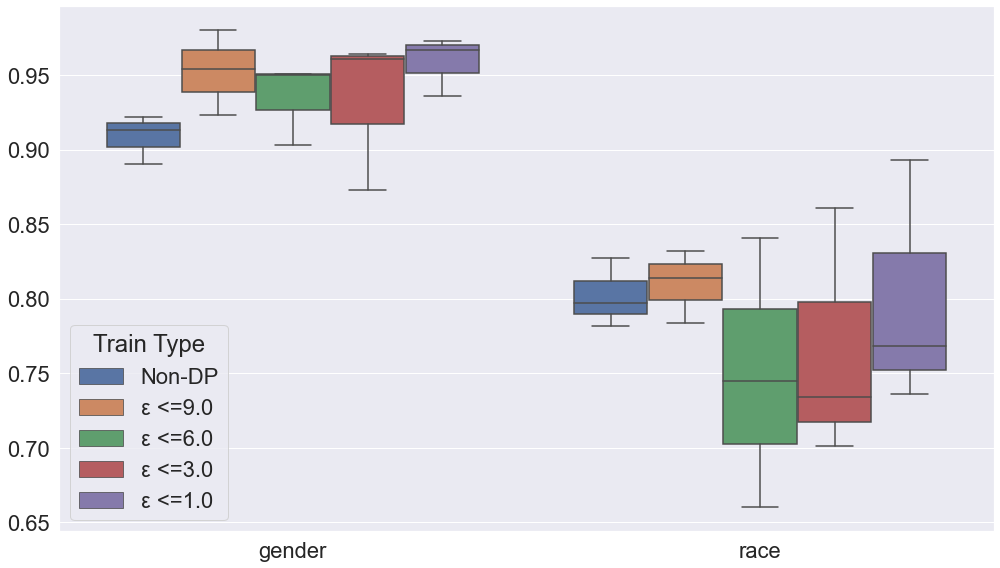

In [9]:
plt.figure(figsize=figsize)
sns.boxplot(x = 'Subgroup', y = 'Metric', hue='Train Type', hue_order=hue_order, data = df)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'eodds_boxplot.pdf'))

In [10]:
# grouped = df.groupby(['Train Type', 'Subgroup'])[['Metric']].agg('mean').reset_index()
# plt.figure(figsize=(16,8))
# sns.lineplot(x ='Train Type', y = 'Metric', hue='Subgroup', data = grouped)

## Overall result

In [11]:
total = []
for epsilon in ['None']+epsilon_list:
    mean = overall_results_dict[epsilon].groupby('metrics').aggregate('mean').reset_index()
    mean['Train Type'] = key_map(epsilon)
    total.append(mean)

In [12]:
total_df = pd.concat(total)
total_df.rename({col:col.split('_')[-1] for col in total_df.columns if 'target_' in col}, axis=1, inplace=True)
total_df.head()

,metrics,men,women,white,black,Total,Train Type
0,accuracy,0.791667,0.751000,0.786333,0.820000,0.802,Non-DP
1,auc,0.814333,0.810667,0.800333,0.882000,0.849,Non-DP
2,bnsp_auc,0.836000,0.860667,0.808333,0.919333,NaN,Non-DP
3,bpsn_auc,0.835333,0.817667,0.847667,0.800667,NaN,Non-DP
4,f1_score,0.554000,0.620333,0.534333,0.786000,0.632,Non-DP


### Total dataset

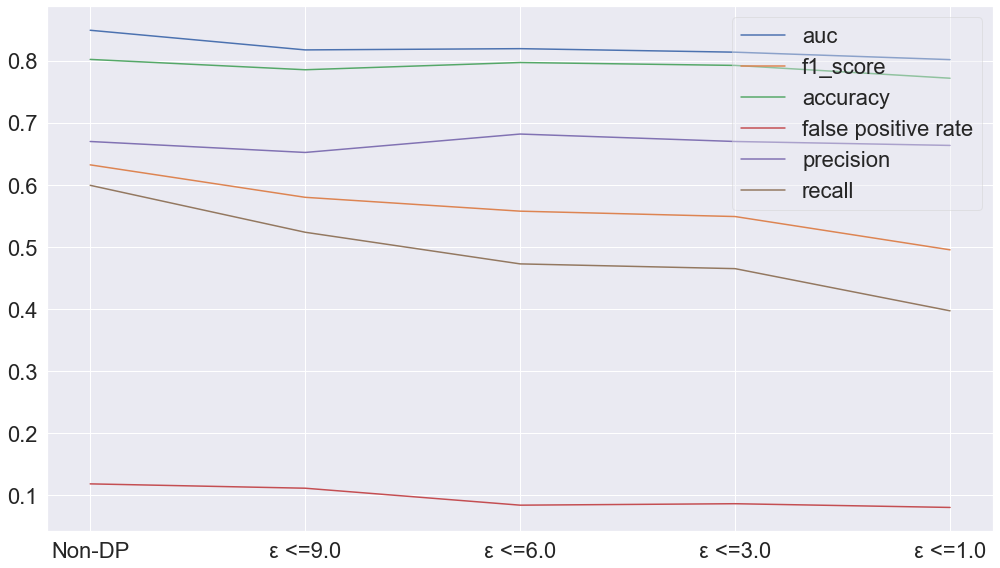

In [13]:
selected_metrics = ['auc', 'f1_score', 'accuracy', 'false positive rate', 'precision', 'recall']
plt.figure(figsize=figsize)

for selected_metric in selected_metrics:
    selected_df = total_df[total_df['metrics']==selected_metric]
    selected_df = order(selected_df)
    plt.plot(selected_df["Train Type"], selected_df["Total"], label=selected_metric)

plt.legend(loc='upper right', fancybox=True, framealpha=0.4)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'overall_total.pdf'))
plt.show()

### Util plot_overall_metric

In [14]:
def plot_overall_metric(selected_metric, title=None, figure_name=None):
    plt.figure(figsize=figsize)
    selected_df = total_df[total_df['metrics']==selected_metric]
    selected_df = order(selected_df)

    for identity in identities:
        plt.plot(selected_df["Train Type"], selected_df[identity], label=identity)

    plt.legend(loc='upper right', fancybox=True, framealpha=0.4)
    if title:
        plt.title(title)
    plt.tight_layout()
    if figure_name:
        plt.savefig(os.path.join(output_folder, figure_name))
    plt.show()

### BNSP

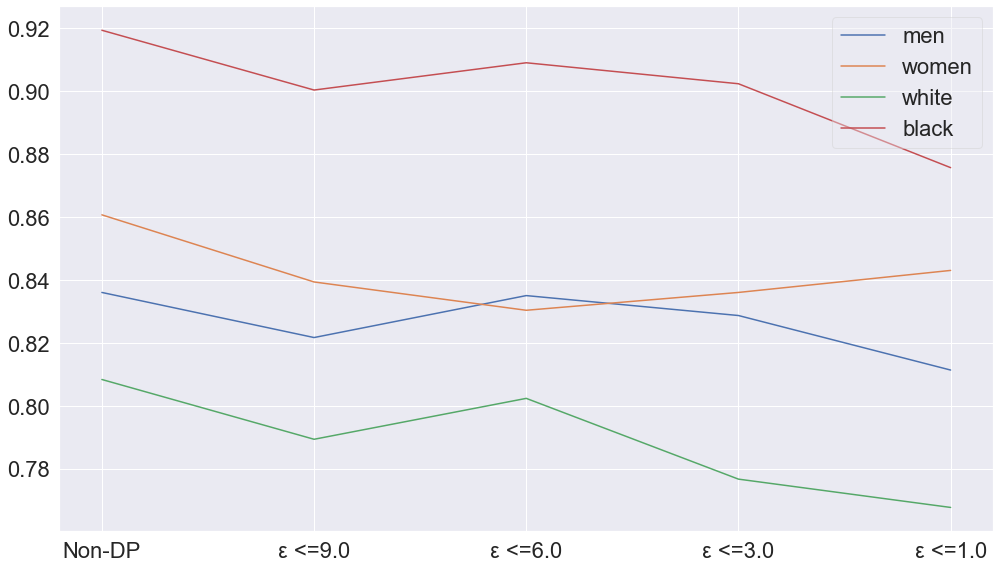

In [15]:
plot_overall_metric('bnsp_auc', figure_name='bnsp.pdf')

### BPSN

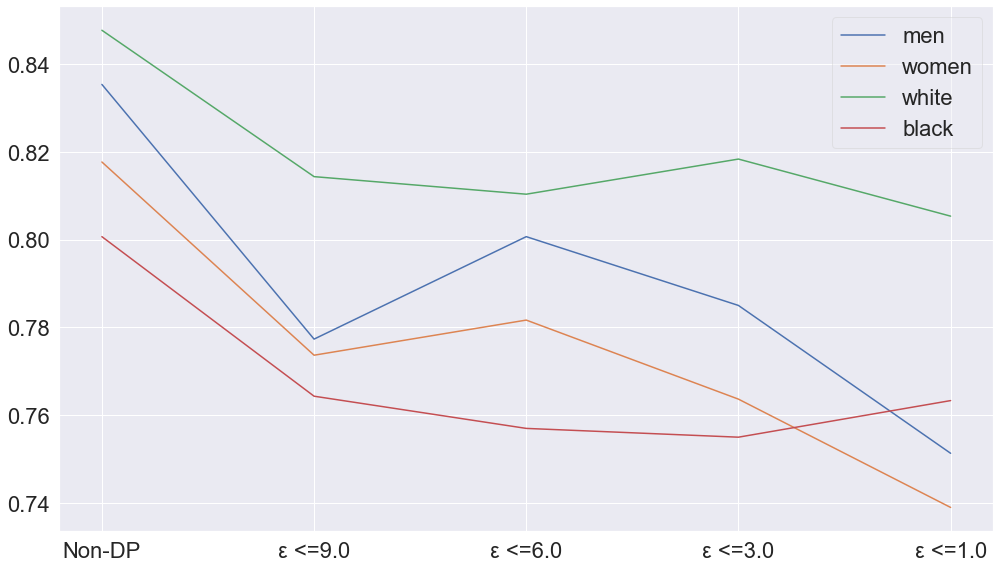

In [16]:
plot_overall_metric('bpsn_auc', figure_name= 'bpsn.pdf')

### Subgroup auc

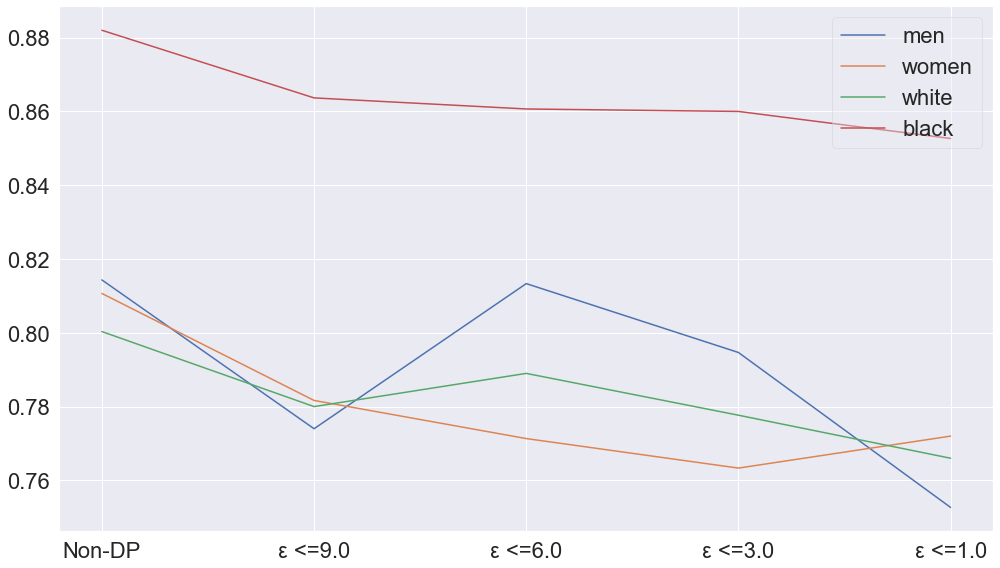

In [17]:
plot_overall_metric('auc', figure_name='roc_auc.pdf')

### F1-score

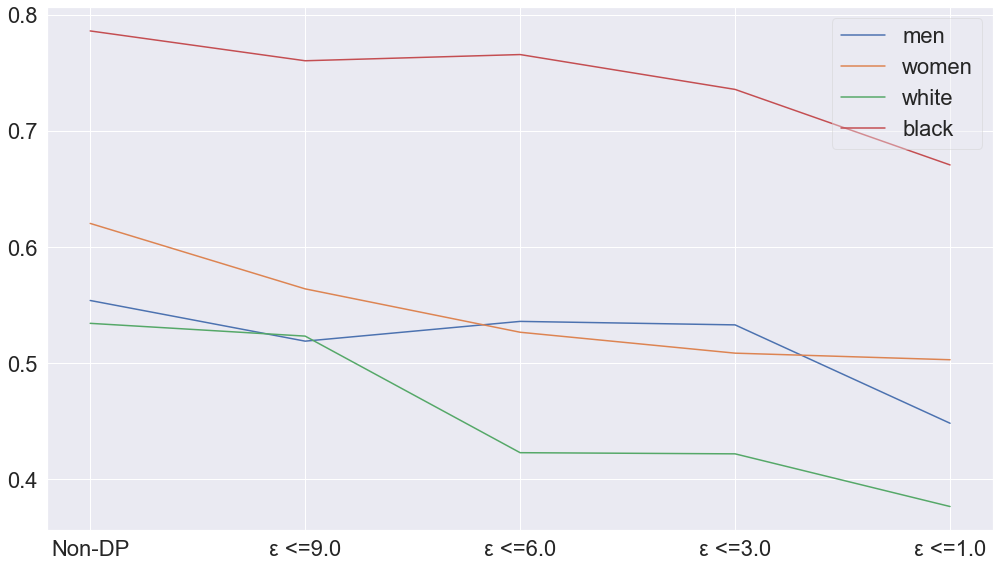

In [18]:
plot_overall_metric('f1_score', figure_name= 'f1_score.pdf')

### False positive rate

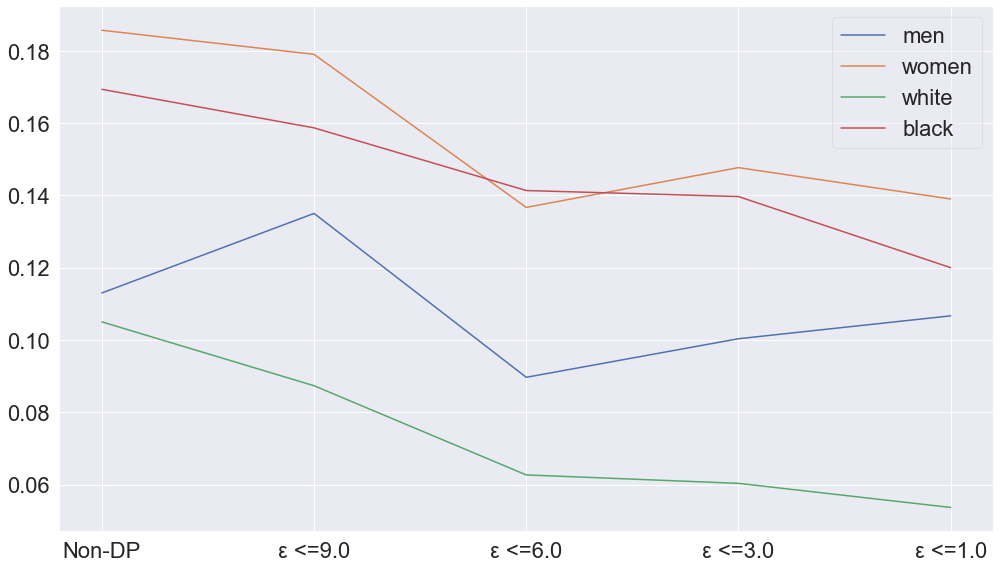

In [19]:
plot_overall_metric('false positive rate', figure_name= 'false_positive_rate.pdf')

## Bias

In [20]:
total = []
for epsilon in ['None']+epsilon_list:
    mean = bias_df_dict[epsilon].groupby('fairness_metrics').aggregate('mean').reset_index()
    mean['Train Type'] = key_map(epsilon)
    total.append(mean)

total_df = pd.concat(total)
total_df.head()

,fairness_metrics,gender,race,Train Type
0,DP,0.455667,0.505667,Non-DP
1,EqOdd,0.908333,0.802000,Non-DP
2,EqOpp0,0.927333,0.935333,Non-DP
3,EqOpp1,0.889333,0.669000,Non-DP
4,accuracy,0.771333,0.803333,Non-DP


### Util plot_bias_metric

In [21]:
def plot_bias_metric(category, title=None, figure_name= None):
    plt.figure(figsize=figsize)
    metric_column = 'fairness_metrics'
    selected_metrics = total_df[metric_column].unique()
    
    for selected_metric in selected_metrics:
        selected_df = total_df[total_df[metric_column]==selected_metric]
        selected_df = order(selected_df)
        
        plt.plot(selected_df["Train Type"], selected_df[category], label=selected_metric)

    plt.legend(loc='upper right', fancybox=True, framealpha=0.5)
    if title:
        plt.title(title)
    plt.tight_layout()
    if figure_name:
        plt.savefig(os.path.join(output_folder, figure_name))

    plt.show()

### Race

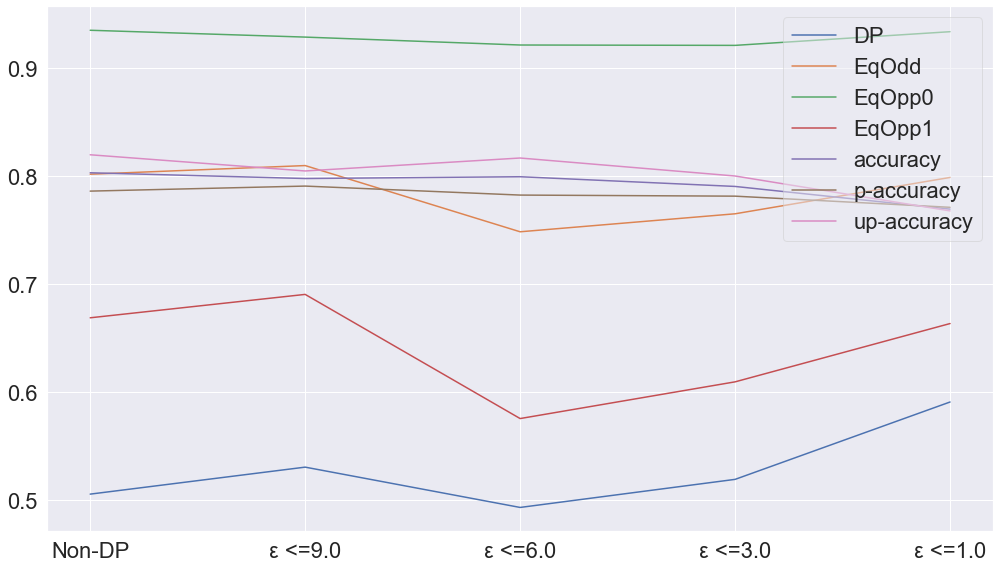

In [22]:
plot_bias_metric('race', figure_name='racial_bias.pdf')

### Gender

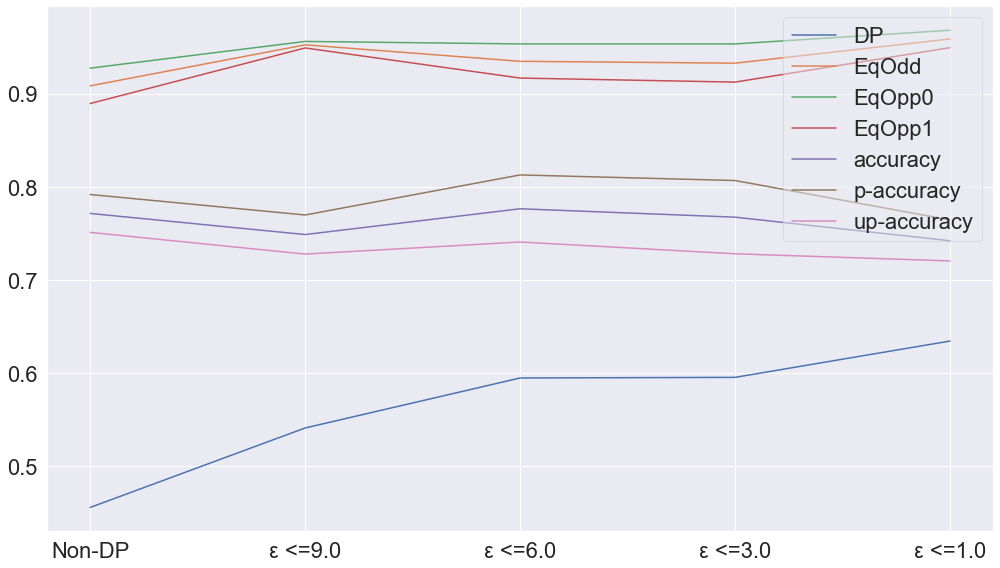

In [23]:
plot_bias_metric('gender', figure_name='gender_bias.pdf')